In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
file_path = '../data/processed/Juegorawg_limpio.csv'
df = pd.read_csv(file_path)
df.copy()

,slug,name,playtime,released,rating,rating_top,ratings_count,reviews_text_count,added,metacritic,suggestions_count,updated,reviews_count,release_year,main_genre,metacritic_category
0,hellpoint,Hellpoint,3,2020-07-30,2.76,3,51,2,2182,61.0,494,2024-11-26 14:58:37,54,2020,Indie,Media
1,anomaly-2,Anomaly 2,2,2013-05-14,2.90,4,62,0,1898,77.0,610,2024-10-07 11:59:32,62,2013,Strategy,Media
2,reverse-4,Resident Evil Re:Verse,1,2022-10-28,1.53,1,63,0,1662,78.0,456,2024-11-14 19:49:03,64,2022,Shooter,Media
3,x-morph-defense,X-Morph: Defense,3,2017-08-30,3.08,3,47,1,1657,75.0,702,2024-11-08 09:09:44,48,2017,Indie,Media
4,west-of-dead,West of Dead,1,2020-06-08,3.08,3,64,2,1634,68.0,456,2024-03-05 13:43:19,66,2020,Indie,Media
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3763,the-otterman-empire,The Otterman Empire,0,2020-07-02,0.00,0,0,0,0,76.5,333,2020-12-16 15:29:54,0,2020,Casual,Media
3764,jacks-or-better-video-poker,Jacks or Better - Video Poker,0,2020-06-12,0.00,0,0,0,0,76.5,0,2022-04-29 05:58:06,0,2020,Casual,Media
3765,jumanji-the-curse-returns,Jumanji: The Curse Returns,0,2021-09-01,0.00,0,0,0,0,76.0,251,2022-09-19 08:16:26,0,2021,Adventure,Media
3766,avocuddle,AvoCuddle,0,2019-07-12,0.00,0,0,0,0,73.0,400,2020-12-16 14:38:36,0,2019,Indie,Media


## Quiero analizar la curtuosis de la variable rating

In [4]:
from scipy.stats import kurtosis, skew

# Calcular la curtosis y asimetría de la variable 'rating'

In [5]:
if 'rating' in df.columns:
    rating_kurt = kurtosis(df['rating'].dropna(), fisher=True)
    rating_skew = skew(df['rating'].dropna())
    rating_kurt, rating_skew
else:
    "La columna 'rating' no existe en el dataset."

In [6]:
print(rating_kurt)
print(rating_skew)

-1.7185997535321695
0.29623199669677414


# 🧠 Curtosis: 0.13
- Está muy cerca de 0, lo que indica que la distribución del rating es mesocúrtica → similar a una distribución normal.

- No hay colas extremadamente pesadas ni picos afilados.

### ✅ Interpretación:

1. "La variable rating presenta una distribución relativamente normal en cuanto a su forma, sin muchos valores extremos."

# 🔄 Asimetría: -0.49
- Es ligeramente negativa, lo que significa que la distribución tiene una cola más larga hacia la izquierda.

- Es decir, hay algunos juegos con ratings bajos, pero la mayoría tiende a agruparse hacia ratings más altos.

### ✅ Interpretación:

2. "Aunque la mayoría de los videojuegos tienen buenas calificaciones, existe un pequeño grupo con ratings muy bajos que inclinan ligeramente la distribución hacia la izquierda."

## Crear caracteristicas derivadas

In [7]:
df['rating_to_count_ratio'] = df['rating'] / (df['ratings_count'] + 1)  # +1 para evitar división por cero
df['reviews_to_ratings_ratio'] = df['reviews_count'] / (df['ratings_count'] + 1)
df['popularity_score'] = (df['ratings_count'] + df['reviews_count'] + df['added']) / 3
df['recency_factor'] = 2025 - df['release_year']  # Cuán reciente es el juego

In [8]:
# Características numéricas relevantes
selected_features = [
    'playtime',           # Tiempo de juego promedio
    'metacritic',         # Puntuación de críticos profesionales
    'ratings_count',      # Número de calificaciones (popularidad)
    'reviews_count',      # Número de reseñas
    'added',              # Veces que el juego fue añadido
    'suggestions_count',  # Número de sugerencias
    'release_year',       # Año de lanzamiento
    'rating_to_count_ratio',    # Tus características derivadas
    'reviews_to_ratings_ratio',
    'popularity_score',
    'recency_factor',
    'rating_top'
]

# Características categóricas para codificar
categorical_features = [
    'main_genre',          # Género principal del juego
    'metacritic_category'  # Categoría de Metacritic
]


### Crear DataFrames con las nuevas columnas

In [9]:
# Método alternativo con pd.get_dummies
df_encoded = pd.get_dummies(df, columns=['main_genre', 'metacritic_category'], drop_first=True)

In [10]:
df_encoded

,slug,name,playtime,released,rating,rating_top,ratings_count,reviews_text_count,added,metacritic,...,main_genre_Indie,main_genre_Massively Multiplayer,main_genre_Platformer,main_genre_Puzzle,main_genre_RPG,main_genre_Racing,main_genre_Shooter,main_genre_Strategy,metacritic_category_Baja,metacritic_category_Media
0,hellpoint,Hellpoint,3,2020-07-30,2.76,3,51,2,2182,61.0,...,True,False,False,False,False,False,False,False,False,True
1,anomaly-2,Anomaly 2,2,2013-05-14,2.90,4,62,0,1898,77.0,...,False,False,False,False,False,False,False,True,False,True
2,reverse-4,Resident Evil Re:Verse,1,2022-10-28,1.53,1,63,0,1662,78.0,...,False,False,False,False,False,False,True,False,False,True
3,x-morph-defense,X-Morph: Defense,3,2017-08-30,3.08,3,47,1,1657,75.0,...,True,False,False,False,False,False,False,False,False,True
4,west-of-dead,West of Dead,1,2020-06-08,3.08,3,64,2,1634,68.0,...,True,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3763,the-otterman-empire,The Otterman Empire,0,2020-07-02,0.00,0,0,0,0,76.5,...,False,False,False,False,False,False,False,False,False,True
3764,jacks-or-better-video-poker,Jacks or Better - Video Poker,0,2020-06-12,0.00,0,0,0,0,76.5,...,False,False,False,False,False,False,False,False,False,True
3765,jumanji-the-curse-returns,Jumanji: The Curse Returns,0,2021-09-01,0.00,0,0,0,0,76.0,...,False,False,False,False,False,False,False,False,False,True
3766,avocuddle,AvoCuddle,0,2019-07-12,0.00,0,0,0,0,73.0,...,True,False,False,False,False,False,False,False,False,True


In [11]:
# 1. Matriz de correlación con la variable objetivo (asumiendo que 'rating' es la variable objetivo)
# Seleccionar columnas numéricas para la correlación
numeric_cols = df_encoded.select_dtypes(include=[np.number]).columns
correlation_matrix = df_encoded[numeric_cols].corr()

# Visualizar la correlación con 'rating'
plt.figure(figsize=(12, 8))
correlation_with_rating = correlation_matrix['rating'].sort_values(ascending=False)
correlation_with_rating = correlation_with_rating.drop('rating')  # Eliminar autocorrelación

<Figure size 1200x800 with 0 Axes>

Top 15 características con mayor correlación con rating:
rating_top                  0.907374
rating_to_count_ratio       0.748830
reviews_to_ratings_ratio    0.698463
reviews_count               0.696376
ratings_count               0.694060
popularity_score            0.571768
added                       0.543338
playtime                    0.351602
reviews_text_count          0.317598
suggestions_count           0.165635
recency_factor              0.092193
release_year               -0.092193
metacritic                 -0.047214
Name: rating, dtype: float64


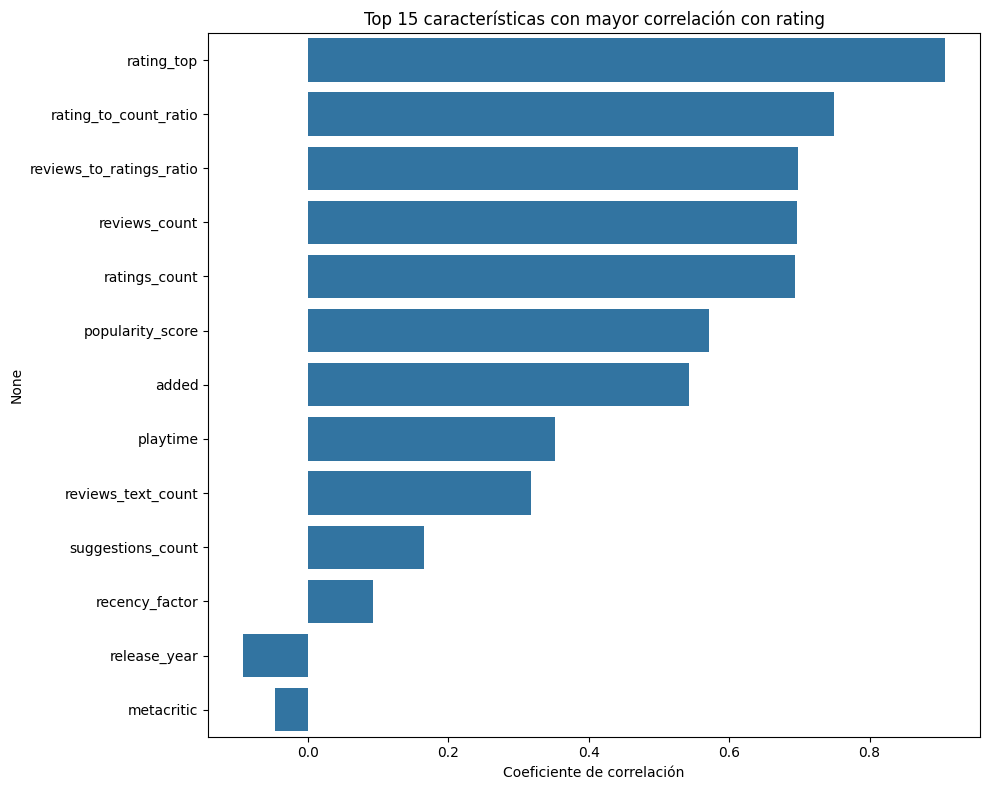

In [ ]:
# Mostrar las 15 características con mayor correlación (
top_features = correlation_with_rating.abs().sort_values(ascending=False).head(15).index
plt.figure(figsize=(10, 8))
sns.barplot(x=correlation_with_rating[top_features], y=top_features)
plt.title('Top 15 características con mayor correlación con rating')
plt.xlabel('Coeficiente de correlación')
plt.tight_layout()


# Imprimir las correlaciones más importantes
print("Top 15 características con mayor correlación con rating:")
print(correlation_with_rating[top_features])

In [13]:
important_features = [
    'rating_top',
    'rating_to_count_ratio',
    'reviews_to_ratings_ratio',
    'reviews_count',
    'ratings_count',
    'popularity_score',
    'added'
]

## Entrenamos modelo de Regresion

In [14]:
X = df[important_features]
y = df['rating']  # variable objetivo

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Escalar características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
# Función para evaluar modelos
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Entrenar modelo
    model.fit(X_train, y_train)
    
    # Predecir
    y_pred = model.predict(X_test)
    
    # Calcular métricas
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Validación cruzada
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    
    # Guardar resultados
    results = {
        'Model': model_name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'CV R² (mean)': cv_scores.mean(),
        'CV R² (std)': cv_scores.std()
    }
    
    return results, y_pred, model

In [18]:
# Crear y evaluar diferentes modelos
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

results_list = []
predictions = {}
trained_models = {}

In [19]:
for name, model in models.items():
    result, y_pred, trained_model = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test, name)
    results_list.append(result)
    predictions[name] = y_pred
    trained_models[name] = trained_model

In [20]:
# Crear DataFrame con resultados
results_df = pd.DataFrame(results_list)
print("Comparación de modelos:")
print(results_df)

# Encontrar el mejor modelo basado en R²
best_model_name = results_df.loc[results_df['R²'].idxmax()]['Model']
print(f"\nMejor modelo: {best_model_name}")

Comparación de modelos:
               Model       MSE      RMSE       MAE        R²  CV R² (mean)  \
0  Linear Regression  0.154442  0.392991  0.242797  0.943229     -0.115731   
1   Ridge Regression  0.154069  0.392516  0.243146  0.943366     -0.124857   
2   Lasso Regression  0.166913  0.408550  0.280221  0.938645     -1.422026   
3      Random Forest  0.015996  0.126476  0.063079  0.994120      0.960144   
4  Gradient Boosting  0.031102  0.176356  0.099608  0.988567      0.947631   

   CV R² (std)  
0     1.697337  
1     1.692476  
2     3.017129  
3     0.054447  
4     0.064252  

Mejor modelo: Random Forest


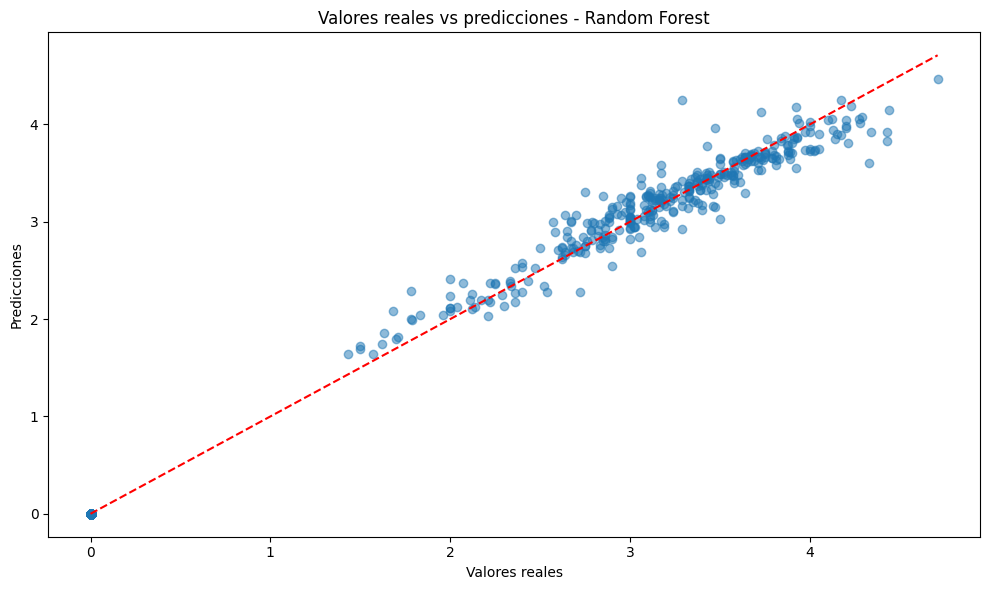

In [21]:
# Visualizar predicciones vs valores reales para el mejor modelo
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions[best_model_name], alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title(f'Valores reales vs predicciones - {best_model_name}')
plt.tight_layout()


Importancia de características:
                    Feature  Importance
1     rating_to_count_ratio    0.906973
0                rating_top    0.041732
3             reviews_count    0.041053
4             ratings_count    0.004462
6                     added    0.002488
2  reviews_to_ratings_ratio    0.001939
5          popularity_score    0.001353

Se han generado gráficos para analizar el modelo.


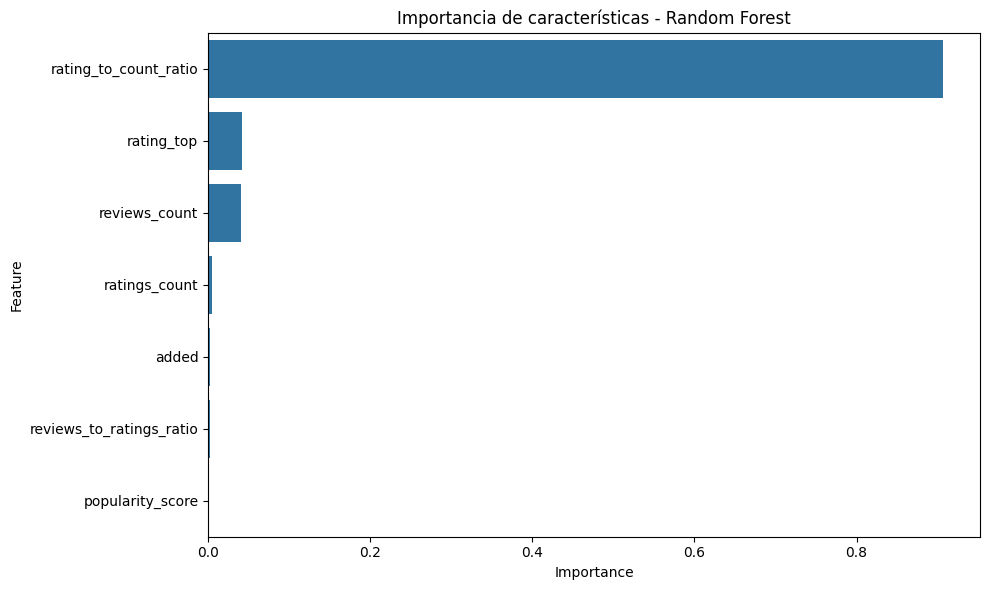

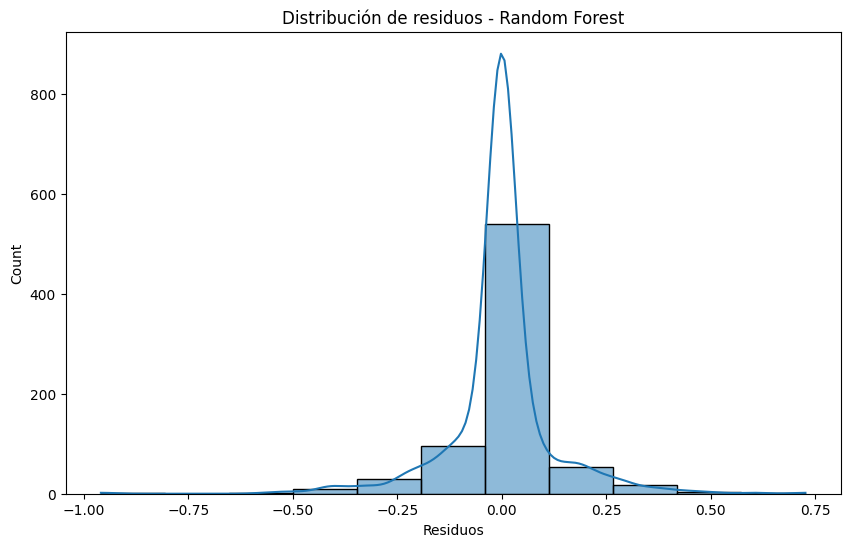

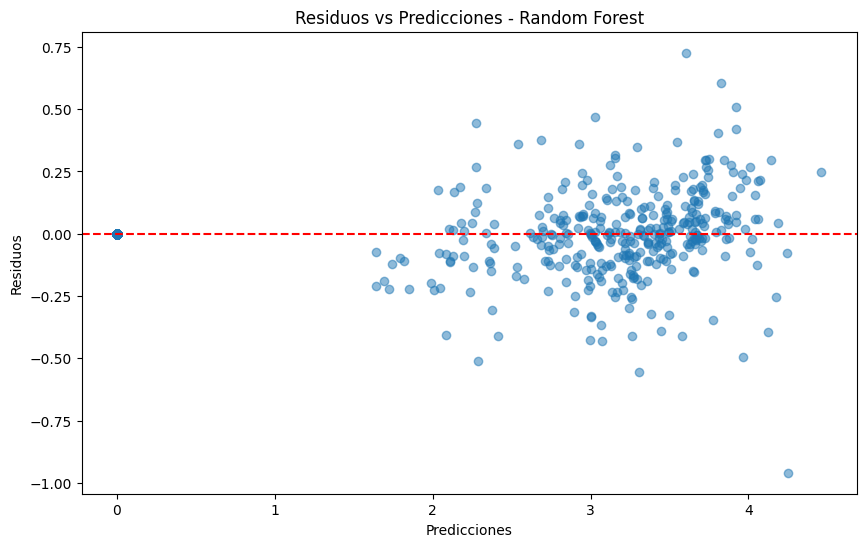

In [24]:
# Analizar importancia de características para el mejor modelo
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    # Para modelos basados en árboles
    feature_importance = pd.DataFrame({
        'Feature': important_features,
        'Importance': trained_models[best_model_name].feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title(f'Importancia de características - {best_model_name}')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    
    print("\nImportancia de características:")
    print(feature_importance)
else:
    # Para modelos lineales
    coefficients = pd.DataFrame({
        'Feature': important_features,
        'Coefficient': trained_models[best_model_name].coef_
    }).sort_values('Coefficient', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Coefficient', y='Feature', data=coefficients)
    plt.title(f'Coeficientes - {best_model_name}')
    plt.tight_layout()
    plt.savefig('coefficients.png')
    
    print("\nCoeficientes del modelo:")
    print(coefficients)

# Análisis de residuos para el mejor modelo
residuals = y_test - predictions[best_model_name]

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title(f'Distribución de residuos - {best_model_name}')
plt.xlabel('Residuos')
plt.savefig('residuals_distribution.png')

plt.figure(figsize=(10, 6))
plt.scatter(predictions[best_model_name], residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title(f'Residuos vs Predicciones - {best_model_name}')
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.savefig('residuals_vs_predictions.png')

print("\nSe han generado gráficos para analizar el modelo.")